In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
import pickle
from minisom import MiniSom

In [226]:
vectorizedSentences = []
bestWordsFromSentences = []
allWordsFromSentences = []
allSentences = []
with open("data/vectorized_sentences", "rb") as fp:   # Unpickling
    vectorizedSentences = pickle.load(fp)
with open("data/best_words_for_sentences", "rb") as fp:   # Unpickling
    bestWordsFromSentences = pickle.load(fp)
with open("data/all_words_for_sentences", "rb") as fp:   # Unpickling
    allWordsFromSentences = pickle.load(fp)
with open("data/all_sentences", "rb") as fp:   # Unpickling
    allSentences = pickle.load(fp)
uniqueResultTuples = pd.read_csv("data/unique_result_tuples.csv")

In [204]:
uniqueResultTuples

,Unnamed: 0,prawo cywilne,prawo administracyjne,prawo farmaceutyczne,prawo pracy,prawo medyczne,prawo karne,prawo miädzynarodowe,prawo podatkowe,prawo konstytucyjne
0,words,"[('spadku', 46), ('uchwały', 24), ('spadek', 2...","[('danych', 48), ('osobowych', 32), ('budowę',...","[('aptekę', 13), ('receptę', 12), ('zezwolenia...","[('pracownika', 78), ('wypoczynkowego', 29), (...","[('specjalizacji', 52), ('dodatku', 46), ('cov...","[('przesłuchaniu', 23), ('przestępstwa', 9), (...","[('bezpieczeństwa', 3), ('granicami', 2), ('ar...","[('kas', 5), ('fiskalną', 4), ('kasę', 3), ('f...","[('konstytucją', 2), ('wyjść', 2)]"


In [205]:
def calculate_empty_lists(list: list):
    emptyLists = 0
    for l in list:
        if len(l) == 0:
            emptyLists+=1
    return emptyLists

VECTORIZED SENTENCES

In [206]:
tags = ['prawo cywilne','prawo administracyjne','prawo farmaceutyczne','prawo pracy','prawo medyczne','prawo międzynarodowe','prawo podatkowe','prawo konstytucyjne','prawo karne','inne']
colors = ['orange','red','blue','green','cyan','brown','black','purple','pink','#42458f']
def get_category_index(vector):
    index = 0
    value = 0
    for i, v in enumerate(vector):
        if v > value:
            value = v
            index = i
    return index

In [207]:
W = np.array(vectorizedSentences)

In [208]:
map_dim = 20
som = MiniSom(map_dim, map_dim, 10, sigma=1.0, random_seed=1)
# som.random_weights_init(W)
som.train_batch(W, num_iteration=len(W)*100, verbose=True)

 [ 267200 / 267200 ] 100% - 0:00:00 left 
 quantization error: 0.0067783478232555745


In [227]:
def get_best_word_from_list(affair: str,words: list):
    if affair == 'prawo międzynarodowe':
        affair = 'prawo miädzynarodowe'
    b = eval(uniqueResultTuples[affair][0])
    value = 0
    result = ''
    for word in words:
        for tuple in b:
            if tuple[0] == word and tuple[1] > value:
                value = tuple[1]
                result = word
    if len(words) > 0 and result == '':
        result = words[0]
    return result

In [228]:
def change_best_words_to_best_word():
    result = []
    for i,list in enumerate(bestWordsFromSentences):
        categoryIndex = get_category_index(vectorizedSentences[i])
        category = tags[categoryIndex]
        if len(list) == 1:
            result.extend(list)
        else:
            result.append(get_best_word_from_list(category,list))
    return result
bestWordsFromSentences = change_best_words_to_best_word()

In [211]:
bestWordsFromSentences

['lokali',
 'pomieszczenie',
 '',
 'niepełnosprawnych',
 'uchwałą',
 'uchwały',
 'jaką',
 'skład',
 'uchwały',
 'uchwały',
 'lokali',
 'ogrzewania',
 'lokali',
 '',
 'granicy',
 'uchwały',
 'uchwały',
 '',
 'właścicielka',
 'parkingowym',
 'naprawy',
 'starego',
 'uchwały',
 'zarządca',
 'bankowych',
 'osobowe',
 'głosów',
 'kosztach',
 'wymienić',
 'roszczenie',
 'wartość',
 'budowlanego',
 'salonu',
 'wieczystej',
 'utraconego',
 '',
 'podejrzeniem',
 'stażysta',
 'będzie',
 'zawodowego',
 'dziedziczenia',
 'zatrudniona',
 'zaległe',
 'pani',
 '',
 '',
 'skład',
 'drodze',
 '',
 'pracować',
 '',
 '',
 'przyjęcia',
 'farmacji',
 'drugą',
 'własną',
 'winna',
 'własną',
 '',
 'lekarza',
 'charakterze',
 '',
 'zakazu',
 'szpitalem',
 'podpisanie',
 '',
 'oblicza',
 'właścicielu',
 'pracować',
 'zadań',
 'karnym',
 'skrócenia',
 'równoważnym',
 '',
 'dokumentację',
 '',
 'tomografii',
 'zezwolenia',
 'ochrona',
 'szpitalnej',
 'kategorii',
 'przestępstwa',
 'innych',
 'doprowadzić',
 'do

In [229]:
def remove_elements_from_list_by_indexes(list: list, indexes: list):
    result = []
    for i,l in enumerate(list):
        if i not in indexes:
            result.append(l)
    return result

In [230]:
def get_indexes_of_repeated_words():
    toRemove = []
    for i,word in enumerate(bestWordsFromSentences):
        for i2, word2, in enumerate(bestWordsFromSentences):
            if word != 'none' and i != i2 and i2 > i and word == word2:
                toRemove.append(i2)
    return toRemove

indexesToRemove = get_indexes_of_repeated_words()
indexesToRemove = [*set(indexesToRemove)]
print('Got {} repeated words to delete from {}'.format(len(indexesToRemove),len(bestWordsFromSentences)))
bestWords = remove_elements_from_list_by_indexes(bestWordsFromSentences,indexesToRemove)
vectors =  remove_elements_from_list_by_indexes(vectorizedSentences,indexesToRemove)
allWords = remove_elements_from_list_by_indexes(allWordsFromSentences,indexesToRemove)
allSentences = remove_elements_from_list_by_indexes(allSentences,indexesToRemove)

Got 1615 repeated words to delete from 2672


In [231]:
def get_indexes_of_empty_words(list):
    toRemove = []
    for i,word in enumerate(list):
        if word == '':
            toRemove.append(i)
    return toRemove
indexesToRemove = get_indexes_of_empty_words(bestWords)
print('Got {} empty words to delete from {}'.format(len(indexesToRemove),len(bestWords)))
bestWords = remove_elements_from_list_by_indexes(bestWords,indexesToRemove)
vectors =  remove_elements_from_list_by_indexes(vectors,indexesToRemove)
allWords = remove_elements_from_list_by_indexes(allWords,indexesToRemove)
allSentences = remove_elements_from_list_by_indexes(allSentences,indexesToRemove)

Got 1 empty words to delete from 1057


In [215]:
print('bestWords({}) == vectors({}) == allWords({})'.format(len(bestWords),len(vectors),len(allWords)))

bestWords(1056) == vectors(1056) == allWords(1056)


In [232]:
numberOfDocumentsInCategory = [0]*10

def reset_number_of_documents_in_category():
    for index,num in enumerate(numberOfDocumentsInCategory):
        numberOfDocumentsInCategory[index] =0

def update_number_of_documents_in_category(index: int):
    numberOfDocumentsInCategory[index] += 1

def print_number_of_documents_in_category():
    for index, category in enumerate(tags):
        print('{}: {}'.format(category,numberOfDocumentsInCategory[index]))

In [217]:
print(str(len(vectorizedSentences)))
print(str(len(vectors)))

2672
1056


prawo cywilne: 863
prawo administracyjne: 164
prawo farmaceutyczne: 212
prawo pracy: 327
prawo medyczne: 846
prawo międzynarodowe: 7
prawo podatkowe: 61
prawo konstytucyjne: 2
prawo karne: 190
inne: 0


[]

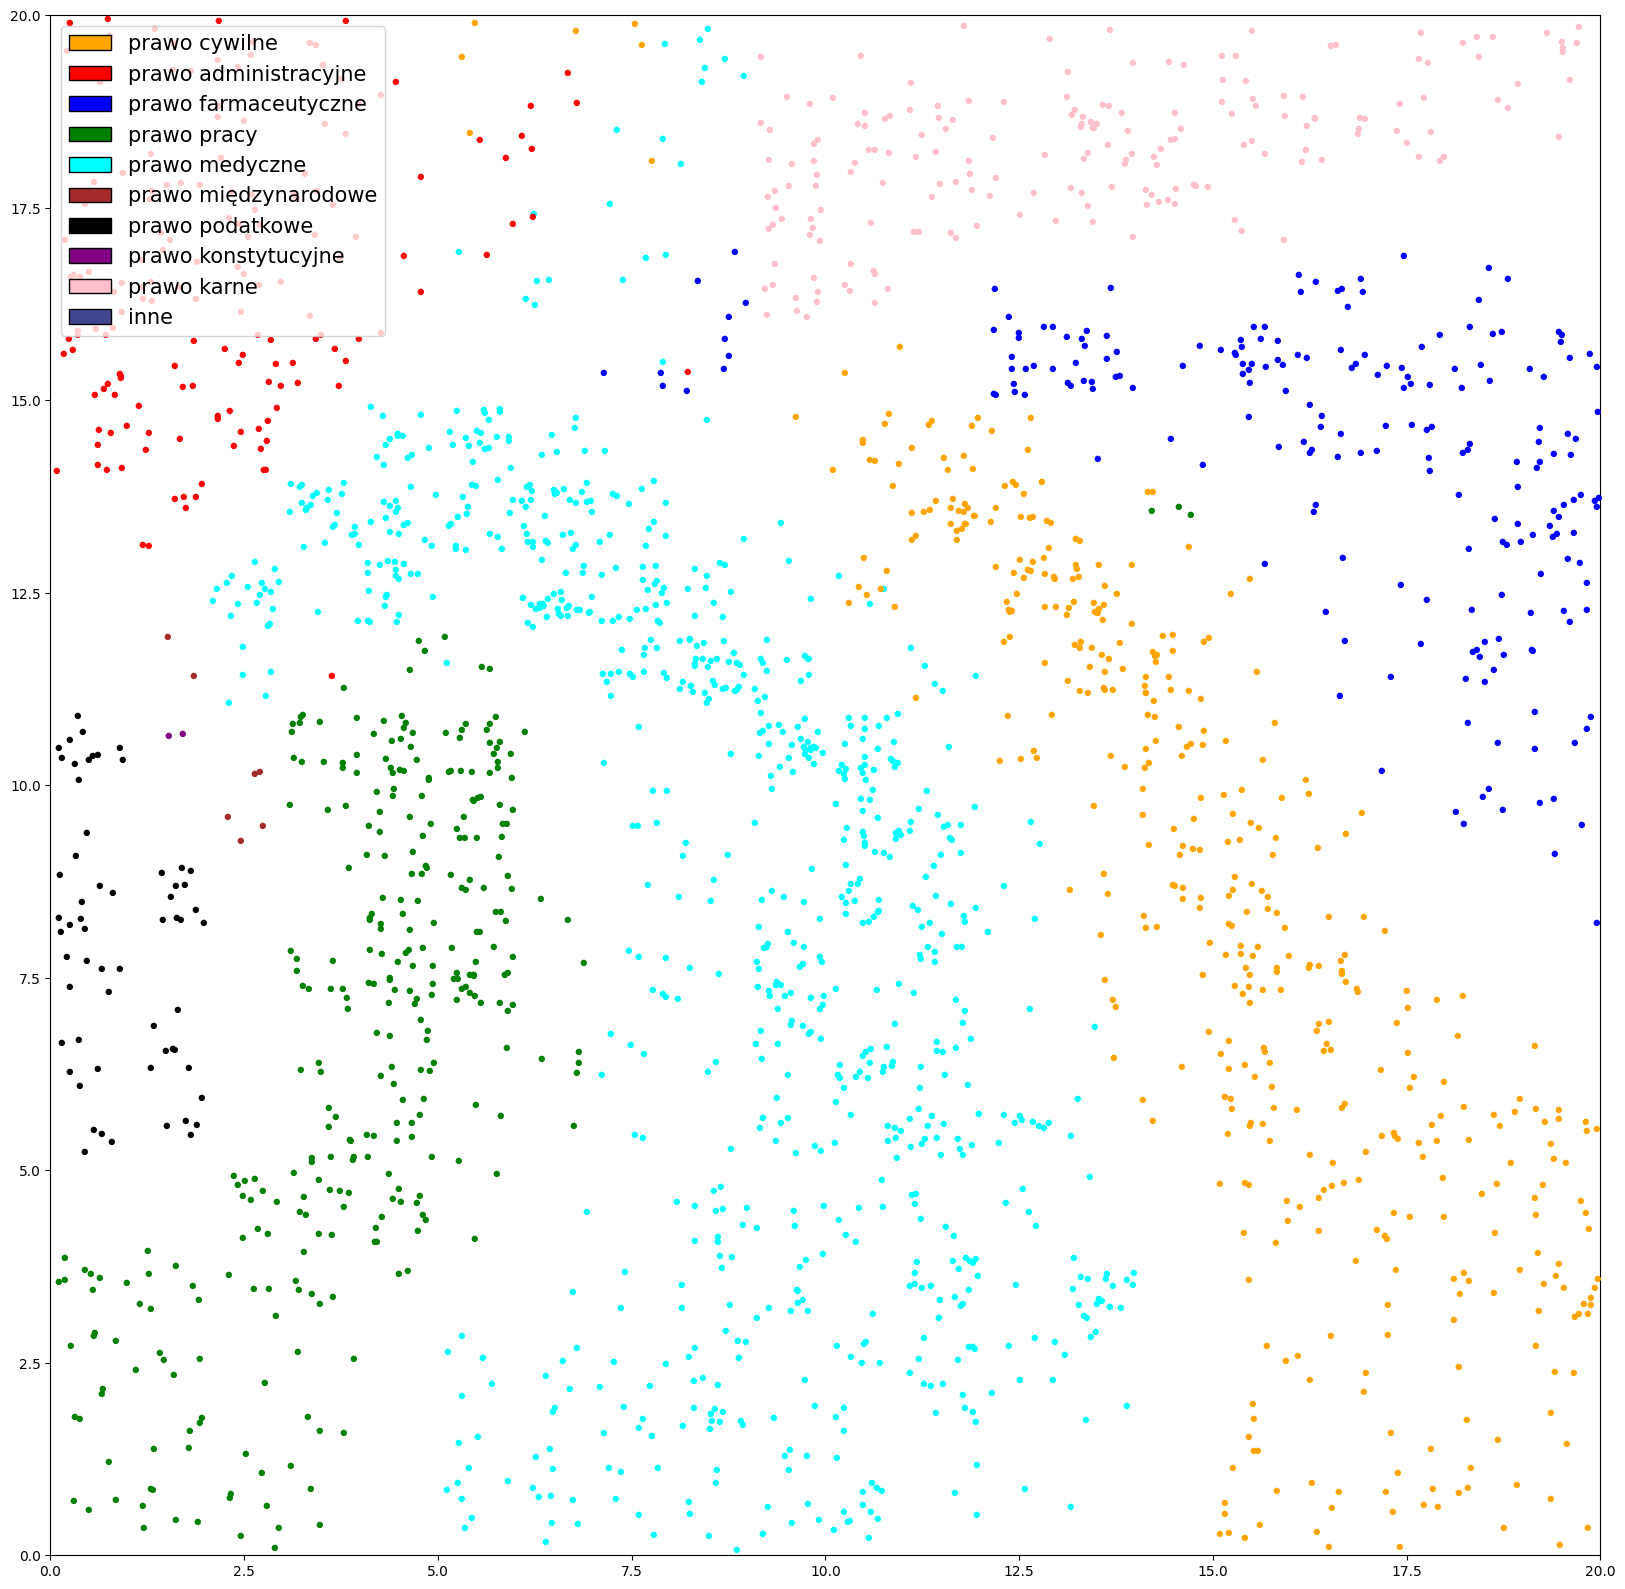

In [218]:
import ast
from matplotlib.patches import Patch
legend_elements = []
for index,color in enumerate(colors):
    c = colors[index]
    l = tags[index]
    legend_elements.append(Patch(facecolor=c, edgecolor='black',label=l))
plt.figure(figsize=(20, 20))
texts = []
reset_number_of_documents_in_category()
for i,vec in enumerate(vectorizedSentences):
    affairIndex = get_category_index(vec)
    update_number_of_documents_in_category(affairIndex)
    c = colors[affairIndex]
    winnin_position = som.winner(vec)
    text = ''
    if len(bestWordsFromSentences[i]) > 0:
        text = bestWordsFromSentences[i]
    if text != "":
        texts.append(plt.text((winnin_position[0]+np.random.rand()*.9)%map_dim, (winnin_position[1]+np.random.rand()*.9)%map_dim, '⚫', color=c))

print_number_of_documents_in_category()

plt.legend(handles=legend_elements, loc='upper left',prop={'size': 15})
# plt.xticks(range(map_dim))
# plt.yticks(range(map_dim))
# plt.grid()
plt.xlim([0, map_dim])
plt.ylim([0, map_dim])
plt.plot()

prawo cywilne: 223
prawo administracyjne: 84
prawo farmaceutyczne: 101
prawo pracy: 154
prawo medyczne: 377
prawo międzynarodowe: 3
prawo podatkowe: 34
prawo konstytucyjne: 2
prawo karne: 78
inne: 0


[]

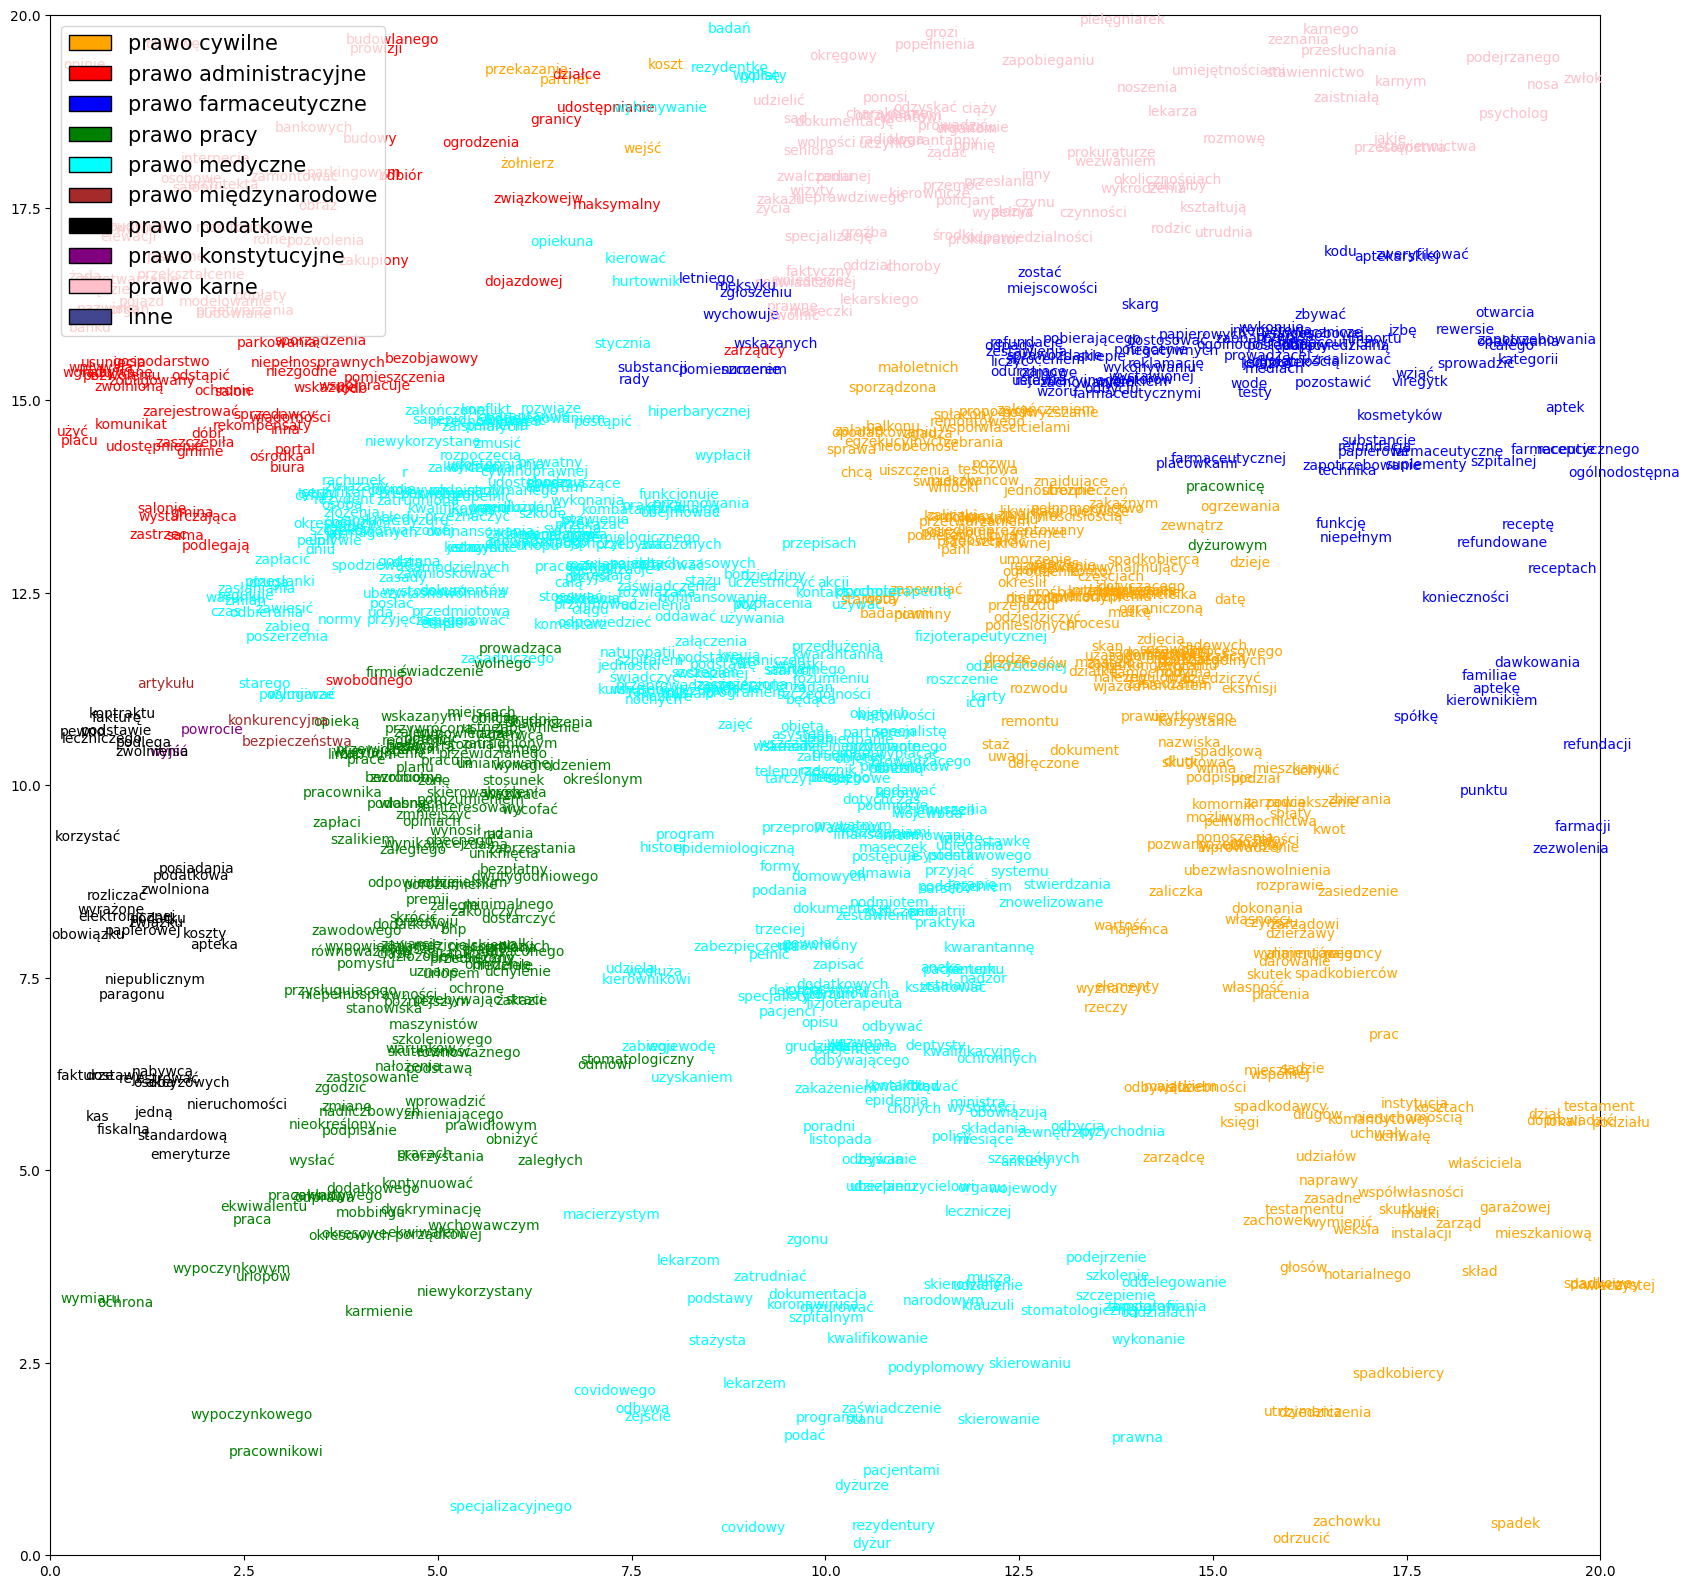

In [219]:
import ast
from matplotlib.patches import Patch
legend_elements = []
for index,color in enumerate(colors):
    c = colors[index]
    l = tags[index]
    legend_elements.append(Patch(facecolor=c, edgecolor='black',label=l))
plt.figure(figsize=(20, 20))
texts = []
reset_number_of_documents_in_category()
for i,vec in enumerate(vectors):
    affairIndex = get_category_index(vec)
    update_number_of_documents_in_category(affairIndex)
    c = colors[affairIndex]
    winnin_position = som.winner(vec)
    text = bestWords[i]
    if text != "":
        texts.append(plt.text((winnin_position[0]+np.random.rand()*.9)%map_dim, (winnin_position[1]+np.random.rand()*.9)%map_dim, text, color=c))

print_number_of_documents_in_category()

plt.legend(handles=legend_elements, loc='upper left',prop={'size': 15})
# plt.xticks(range(map_dim))
# plt.yticks(range(map_dim))
# plt.grid()
plt.xlim([0, map_dim])
plt.ylim([0, map_dim])
plt.plot()

NETWORK GRAPH

In [220]:
def get_category_indexes(vector):
    index = 0
    value = 0
    result = []
    for i, v in enumerate(vector):
        if v > value:
            value = v
            index = i
    for i, v in enumerate(vector):
        if v == value:
            result.append(i)
    return result

In [195]:
import plotly.graph_objects as go

import networkx as nx


G = nx.Graph()

categories = ['prawo cywilne','prawo administracyjne','prawo farmaceutyczne','prawo pracy','prawo medyczne','prawo międzynarodowe','prawo podatkowe','prawo konstytucyjne','prawo karne']
categories_positions = [[15.5,10],[2,16],[17.5,15],[5,7.5],[10,9],[3,10],[1.5,7.5],[2,10.5],[13,18]]
# Add basic nodes for legal affairs
for i, category in enumerate(categories):
    G.add_node(category)

# Add words from vectors
for i, vec in enumerate(vectors):
    categoryIndexes = get_category_indexes(vec)
    if len(categoryIndexes) == 0:
        continue
    w = bestWords[i]
    if len(w) == 1:
        continue
    G.add_node(w)
    for index in categoryIndexes:
        G.add_edge(categories[index],w)

nodes_to_remove = []
for n in G.nodes:
    if type(n) is int:
        nodes_to_remove.append(n)
        continue
    if n not in categories:
        indexOfWord = [x for x in range(len(bestWords)) if bestWords[x] == n][0]
        winner =  som.winner(vectors[indexOfWord])
        G.nodes[n]['pos'] = (winner[0]+np.random.rand()*.9,winner[1]+np.random.rand()*.9)
    else:
        ind = [x for x in range(len(categories)) if categories[x] == n][0]
        G.nodes[n]['pos'] = categories_positions[ind]

for ntr in nodes_to_remove:
    G.remove_node(ntr)

fig = go.Figure(
            layout=go.Layout(
            title='Words segregated by legal affairs + connections between them',
            titlefont=dict(size=16),
            showlegend=False,
            hovermode='closest',
            hoverlabel=dict(
                namelength=-1,
                font=dict(size=10),
            ),
            margin=dict(b=21, l=5, r=5, t=40),
            annotations=[dict(
                text="",
                showarrow=False,
                xref="paper", yref="paper")],
            xaxis=dict(showgrid=False, zeroline=False,showticklabels=False, mirror=True),
            yaxis=dict(showgrid=False, zeroline=False,
showticklabels=False, mirror=True)))

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    fig.add_trace(go.Scatter(
    x=tuple([x0, x1, None]),
    y=tuple([y0, y1, None]),
    line=dict(width=1, color='darkgrey'),
    mode='lines'))


for g_index, node in enumerate(G.nodes()):
    x, y = G.nodes[node]['pos']
    color = 'silver'
    border_color = 'black'
    border_width = 2
    size = 40
    text = ''
    name = node
    if g_index > 8:
        word_index = [x for x in range(len(bestWords)) if bestWords[x] == node][0]
        vector = vectors[word_index]
        ind = get_category_index(vector)
        color = colors[ind]
        size = 10
        border_color = 0
        indexes = get_category_indexes(vector)
        cats = [categories[k] for k in indexes]
        name = '{} | {}\n'.format(name,cats)
    else:
        color = colors[g_index]
        text = str(node).split(' ')[1]

    fig.add_trace(go.Scatter(
    x=[x],
    y=[y],
    text=text,
    name=name,
    mode='markers+text',
    hoverinfo='name',
    marker=dict(
        showscale=True,
        reversescale=True,
        color=color,
        size=size,
        colorbar=dict(
            thickness=1,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(
            color=border_color,
            width = border_width
        ))))

fig.show()

In [237]:
ambiguouslyAssignedDocuments = OrderedDict()
documentIndex = 0
for i, vec in enumerate(vectors):
    documentInfo = OrderedDict()
    categoryIndexes = get_category_indexes(vec)
    if len(categoryIndexes) < 2:
        continue
    documentInfo['Liczba kategorii prawnych'] = len(categoryIndexes)
    documentInfo['Przypisane kategorie prawne'] = [categories[k] for k in categoryIndexes]
    documentInfo['Tekst'] = allSentences[i]
    documentInfo['Wektor słów'] = allWords[i]
    
    ambiguouslyAssignedDocuments[documentIndex] = documentInfo
    documentIndex += 1

dataFrame = pd.DataFrame(ambiguouslyAssignedDocuments)
dataFrame = dataFrame.T
dataFrame = dataFrame.sort_values(by='Liczba kategorii prawnych',ascending=False)

In [250]:
dataFrame.to_markdown('data/all_sentences.md')

In [253]:
dataFrame.to_excel(r'data/all_sentences.xlsx', index=False)

In [251]:
dataFrame

,Tekst,Wektor słów,Kategorie prawne,Liczba kategorii prawnych
33,czy w przypadku w którym księgowy nie dotrzyma...,"[dotrzyma, wezwać, wejść, biura, przekazanych]","[prawo cywilne, prawo administracyjne, prawo p...",5
14,czy data umiejscowiona na blistrze może być uz...,"[blistrze, datę, suplementu]","[prawo cywilne, prawo farmaceutyczne, prawo me...",3
48,czy możliwe jest wyłączenie odpowiedzialności ...,"[zarządcy, skutek, bezpieczeństwa]","[prawo administracyjne, prawo farmaceutyczne, ...",3
24,na jaki maksymalny okres pracodawca może deleg...,"[maksymalny, delegować, wynikającej]","[prawo administracyjne, prawo pracy, prawo med...",3
30,czy apteka może żądać od farmaceuty dostarczen...,"[poświadczonej, koszt, aktach]","[prawo cywilne, prawo medyczne, prawo karne]",3
0,czy wspólnota mieszkaniowa może odzyskać pomie...,"[pomieszczenie, gospodarcze]","[prawo farmaceutyczne, prawo medyczne]",2
28,jaki jest termin na zawiadomienie wskazanych o...,"[wskazanych, wiążą]","[prawo farmaceutyczne, prawo medyczne]",2
29,czy staż klientki będzie wydłużony o czas poby...,"[staż, czas]","[prawo cywilne, prawo medyczne]",2
31,jak przedstawiają się prawa i obowiązki pracow...,"[przedstawiają, pracownika]","[prawo pracy, prawo karne]",2
32,czy lekarze powinni aktualizować swoje dane w ...,"[badań, prowadzi]","[prawo medyczne, prawo karne]",2
